# Work with the extracted stimulated and inhibited cells

In [1]:
# Imports:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import math
import psycopg2
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *
from postgres_analysis_helpers.general import *
from postgres_analysis_helpers.get_data import *
from postgres_analysis_helpers.circstat_functions import *
# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

Loaded analysis helpers: General
Loaded postgres_analysis_helpers -> general
Loaded postgres_analysis_helpers -> get_data
Loaded postgres_analysis_helpers -> circstat_functions


In [2]:
# Database connection check
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Woot! Database connection is established!')

Connecting to the PostgreSQL database...
Woot! Database connection is established!


### Load dataframes 

In [3]:
# 'dataframe_export/excited_cells.pkl'
# 'dataframe_export/inhibited_cells.pkl'

In [4]:
drop_group = ['sample_rate_inp','ibi','stim_freq','analysis_window','salt_window','sample_rate','stim_length','counter_stimuli',\
                     'salt_i','salt_p','ex_latency_mean','ex_latency_median','excited','ex_latency_var','ex_latency_reliabil',\
                     'stats_p_inhib_10','stats_p_inhib_20','stats_p_inhib_30','stats_p_inhib_40','inhibited','inhib_lowest_p',\
                     'inhib_lowest_p_interval','change_point_ms','no_sessions','spiketimes_cluster','stimulus_timepoints',\
                     'sum_1ms','bin_edges_1ms','binnumber_1ms','isi_stats_contam_perc','session_name','filename']

In [5]:
excited_cells = pd.read_pickle('dataframe_export/excited_cells.pkl')
inhibited_cells = pd.read_pickle('dataframe_export/inhibited_cells.pkl')

In [6]:
excited_cells.drop(labels=drop_group,axis=1,inplace=True)
inhibited_cells.drop(labels=drop_group,axis=1,inplace=True)

### Merge the two dataframes with indicator

In [7]:
merge_group = ['animal_id','n_drive_user','session_ts','cluster_no','tetrode_no']

In [8]:
merged_df = excited_cells.merge(inhibited_cells,how='outer',indicator=True) # excited will be "left_only", and inhibited "right_only"

In [9]:
# Display count:
inhibited_only = len(merged_df[merged_df._merge == 'right_only'])
excited_only = len(merged_df[merged_df._merge == 'left_only'])
both = len(merged_df[merged_df._merge == 'both'])

print('Excited only: {}\nInhibited only: {}\nExcited + inhibited: {}\nSum: {}'.format(excited_only,inhibited_only,both,excited_only+inhibited_only+both))

Excited only: 58
Inhibited only: 236
Excited + inhibited: 12
Sum: 306


## Get the rest of the data and compare with the merged_df

In [10]:
stimulus_stats = pd.DataFrame() # create empty dataframe or feed in a base dataframe from before! 
psql = psql_neuroballs(stimulus_stats) # initialize retrieval

dict_ = {'stimulus_tb': ''}
animals_ = ['74470','74471','74933','74935','74472','74473','74956','73358']

stimulus_stats = psql.retrieve_data(dict_,animals_)

78 animals across 5 experimenters found.
Total # of sessions: 8632 (unique clusters: 15361)
8878 entries retrieved.


### Filter. Make sure that the parameters match the ones in excited cells and inhibited cells notebooks!

In [11]:
# Set parameters:
# excitation:
salt_i_thresh = 0.09
salt_p_thresh = 0.05
min_number_sessions = 2 # min number of session for which criteria above have to be fullfilled
pearson_r_thresh = 0.99 # waveform similarity cutoff

# ISI contamination (%)
isi_contam_thresh = 1

# for inhibited cells:
p_inhib_thresh = 0.001 # inhibition threshold
inhib_interval_ = 10

In [12]:
other_cells = stimulus_stats[(stimulus_stats.salt_i < salt_i_thresh) | (stimulus_stats.salt_p >= salt_p_thresh)].copy()
other_cells = other_cells[(other_cells.inhib_lowest_p >= p_inhib_thresh) | (other_cells.inhib_lowest_p_interval <= inhib_interval_)].copy()

In [13]:
drop_subgroup = ['animal_id','n_drive_user','session_ts','cluster_no','tetrode_no']
other_cells = other_cells.drop_duplicates(drop_subgroup).sort_values(by=drop_subgroup).reset_index().copy()

In [14]:
other_cells.drop(['session_name','index'], axis=1,inplace=True)

In [15]:
psql = psql_neuroballs(other_cells) # initialize retrieval
dict_ = {'ISI_tb':'ISI_stats_contam_perc'}
other_cells = psql.retrieve_data(user_sql_tables=dict_,user_sql_filter="NOT LIKE '%las%'")

# filter out ISI contaminations: 
other_cells = other_cells[other_cells.isi_stats_contam_perc < isi_contam_thresh].copy()

Length of input dataframe: 1619
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ISI_tb: ', max=1619), HTML(value='')))

Success. NaNs: 12



### Save other_cells dataframe for later ... 

In [16]:
other_cells.to_pickle('dataframe_export/other_cells.pkl')

### Merge with merged_df from before ... 

In [17]:
merged_df.rename(columns={'_merge':'_merge_exc_inhib'}, inplace=True) # rename the waveform column - "tag" with laser

In [18]:
all_merged_df = merged_df.merge(other_cells, on=merge_group,how='outer',indicator=True)
all_merged_df.rename(columns={'_merge':'_merge_all'}, inplace=True) # rename the waveform column - "tag" with laser

### Clean up and save for later ... 

In [19]:
# clean up dataframe and write label column to it
labels = []
for i in range(len(all_merged_df)):
    if all_merged_df.iloc[i]._merge_all == 'left_only':
        # check if excited / inhibited or both
        if all_merged_df.iloc[i]._merge_exc_inhib == 'left_only':
            labels.append('excited')
        elif all_merged_df.iloc[i]._merge_exc_inhib == 'right_only':
            labels.append('inhibited')
        elif all_merged_df.iloc[i]._merge_exc_inhib == 'both':
            labels.append('both')
        else:
            labels.append('nan')
    else:
        labels.append('rest')

In [20]:
all_merged_df['label'] = labels

In [21]:
drop_group = ['sample_rate_inp','ibi','stim_freq','analysis_window','salt_window','sample_rate','stim_length','counter_stimuli',\
                     'salt_i','salt_p','ex_latency_mean','ex_latency_median','excited','ex_latency_var','ex_latency_reliabil',\
                     'stats_p_inhib_10','stats_p_inhib_20','stats_p_inhib_30','stats_p_inhib_40','inhibited','inhib_lowest_p',\
                     'inhib_lowest_p_interval','change_point_ms',\
                     'isi_stats_contam_perc','mean_wf_laser','mean_wf','pearson_r_wf','_merge_exc_inhib','_merge_all',\
                     'analysis_ts_y','analysis_ts_x','session_name','filename']

In [22]:
all_merged_df.drop(labels=drop_group,axis=1,inplace=True)

In [28]:
all_merged_df.to_pickle('dataframe_export/all_merged_df.pkl')

In [24]:
all_merged_df.head()

,animal_id,cluster_no,n_drive_user,session_ts,tetrode_no,label
0,74472,23,davidcr,2017-09-10 12:41:58,6,excited
1,74472,26,davidcr,2017-09-19 11:36:30,6,excited
2,74472,33,davidcr,2017-09-17 13:27:31,6,excited
3,74472,33,davidcr,2017-09-17 13:27:31,6,excited
4,74472,33,davidcr,2017-09-17 13:27:31,6,excited


### Little summary

In [25]:
print('Excited:    {}'.format(len(all_merged_df[all_merged_df.label == 'excited'])))
print('Inhibited:  {}'.format(len(all_merged_df[all_merged_df.label == 'inhibited'])))
print('Both:       {}'.format(len(all_merged_df[all_merged_df.label == 'both'])))
print('NaN:        {}'.format(len(all_merged_df[all_merged_df.label == 'nan'])))
print('Neither:    {}'.format(len(all_merged_df[all_merged_df.label == 'rest'])))
print('Sum:        {}'.format(len(all_merged_df[all_merged_df.label == 'excited'])+len(all_merged_df[all_merged_df.label == 'inhibited'])+len(all_merged_df[all_merged_df.label == 'both'])+len(all_merged_df[all_merged_df.label == 'rest'])))

Excited:    58
Inhibited:  236
Both:       12
NaN:        0
Neither:    1612
Sum:        1918


### Pie chart of stimulated vs. inhibited vs. all 

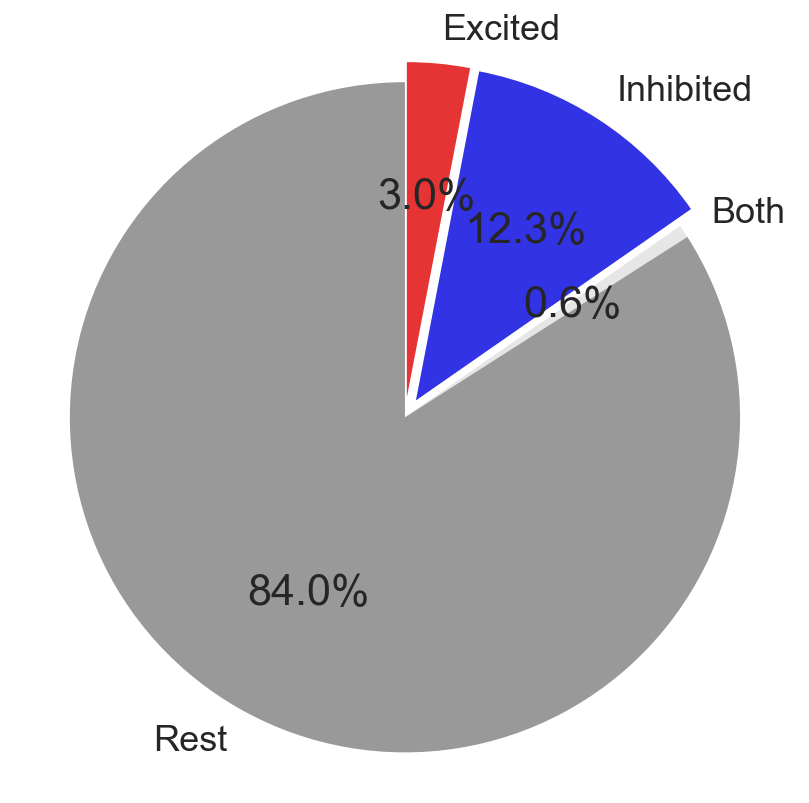

In [26]:
sns.set(font_scale=1.8)
labels = 'Excited', 'Inhibited', 'Both', 'Rest'
sizes = [len(all_merged_df[all_merged_df.label == 'excited']),\
          len(all_merged_df[all_merged_df.label == 'inhibited']),\
              len(all_merged_df[all_merged_df.label == 'both']),\
                len(all_merged_df[all_merged_df.label == 'rest'])]
explode = (.06,.06,0,0)  

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90,counterclock=False,colors=[[.9,.2,.2],[.2,.2,.9],[.9,.9,.9],[.6,.6,.6]])
ax1.axis('equal') 
plt.show()

In [ ]:
all_merged_df

In [30]:
len(all_merged_df)

1918

In [29]:
drop_subgroup = ['animal_id','n_drive_user','session_ts','cluster_no','tetrode_no']

len(all_merged_df.drop_duplicates(subset=drop_subgroup))

1651